# Examples for vireoSNP

In [1]:
import vireoSNP
import numpy as np

from scipy import sparse
from scipy.io import mmread

## Load cellSNP data 

##### Option 1 - VCF format

In [2]:
cell_vcf = vireoSNP.load_VCF("../data/cells.cellSNP.vcf.gz", biallelic_only=True)
cell_dat = vireoSNP.vcf.read_sparse_GeneINFO(cell_vcf['GenoINFO'], keys=['AD', 'DP'])

AD = cell_dat['AD']
DP = cell_dat['DP']

##### Option 2 - sparse matrices

In [3]:
AD = mmread("../data/cellSNP_mat/cellSNP.tag.AD.mtx").tocsc()
DP = mmread("../data/cellSNP_mat/cellSNP.tag.DP.mtx").tocsc()

## Run vireoSNP
Note, `AD` and `DP` are sparse matrices, not `numpy.array`

You need to consider how many allelic ratio categories in your data and your prior values. For example, you could assume there are three:

```python
theta_prior = np.array([[0.01, 1], [1, 1], [1, 0.01]])
```

or three allelic ratios:

```python
theta_prior = np.array([[0.01, 1], [1, 2], [1, 1], [2, 1], [1, 0.01]])
```

Note, the theta prior is the (shape1, shape2) parameters of 
[beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) and shape1 / (shape1 + shape2) is the mean of allelic frequecy.

If you are not sure the number of donors (or clones) in your data sets, you could try a set of numbers, e.g., from 2 to 8, and pick the one when the evidence lower bound stops to fast increase, e.g., 
[Figure 2A in Vireo paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1865-2/figures/2)

In [4]:
theta_prior = np.array([[0.01, 1], [1, 1], [1, 0.01]])

# res = vireoSNP.vireo_core(AD, DP, n_donor=4, learn_GT=True,
#                           theta_prior=theta_prior, learn_theta=True, 
#                           check_doublet=False)

res = vireoSNP.vireo_flock(AD, DP, n_donor=4, learn_GT=True,
                           n_extra_donor=0, #ASE_mode=True,
                           theta_prior=theta_prior, learn_theta=True, 
                           n_init=50, check_doublet=False, random_seed=1)

[vireo] warm-up: 50 random initializations for 4 clusters...
donor3	donor1	donor2	donor0
248	241	232	231
[vireo] warm-up: lower bound ranges [-34370.0, -28574.6, -22125.0]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 28 iterations; lower bound -22071.0
[vireo] beta parameters for binomial rate:
[[440.6 27599.9]
 [17472.2 20458.0]
 [20419.2 1318.1]]


## Clone assignment probability

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6})
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(2, 2.5), dpi=200)
im = heat_matrix(res['ID_prob'], cmap="GnBu", alpha=1,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()

<Figure size 400x500 with 2 Axes>

## Genotype based allelic ratio matrix

In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [7]:
## If ASE_mode is False
AF_mean = res['theta_shapes'][:, 0] / np.sum(res['theta_shapes'], axis=1)
AF_SNPs = np.tensordot(res['GT_prob'], AF_mean, axes=[1, 0])

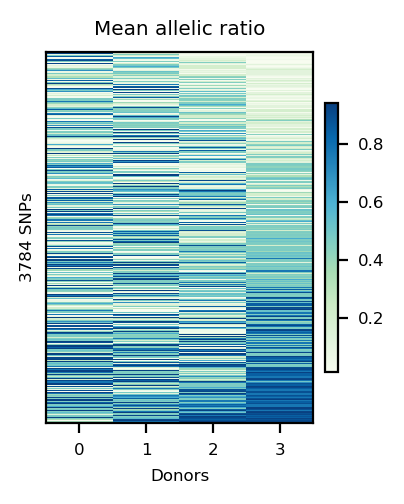

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6})
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(2, 2.5), dpi=200)
im = heat_matrix(AF_SNPs, cmap="GnBu", alpha=1,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Donors")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()

## Vireo with SNP specific allelic specific expression (ASE)

SNP specific ASE mode is supported from version 0.2. This feature could be very useful if there is a strong gene specific or SNP region specific ASE.

However, data is not shared between SNPs in this case, hence the estimation of allelic ratio, i.e., the theta paramters, can be easily overfitted. We can avoid this by introducing a stronger prior to ensure that we won't end up with too flat allelic ratios across all donors (or clones).

In [9]:
theta_prior = np.array([[0.1, 100], [50, 50], [100, 0.1]])

res = vireoSNP.vireo_flock(AD, DP, n_donor=4, learn_GT=True,
                           n_extra_donor=0, ASE_mode=True,
                           theta_prior=theta_prior, learn_theta=True, 
                           n_init=50, check_doublet=False, random_seed=1)

[vireo] warm-up: 50 random initializations for 4 clusters...
donor1	donor2	donor0	donor3
250	242	226	234
[vireo] warm-up: lower bound ranges [-30852.8, -30644.7, -30142.6]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 22 iterations; lower bound -30148.3
[vireo] beta parameters for binomial rate:
[[[0.1 0.1 0.1 ... 0.1 0.1 0.1]
  [101.6 107.6 105.3 ... 100.0 100.0 100.0]]

 [[52.3 51.3 52.0 ... 58.0 58.0 56.3]
  [57.4 54.4 55.7 ... 67.0 67.0 62.0]]

 [[100.7 100.7 100.0 ... 100.0 100.0 100.7]
  [0.1 0.1 0.1 ... 0.1 0.1 0.1]]]


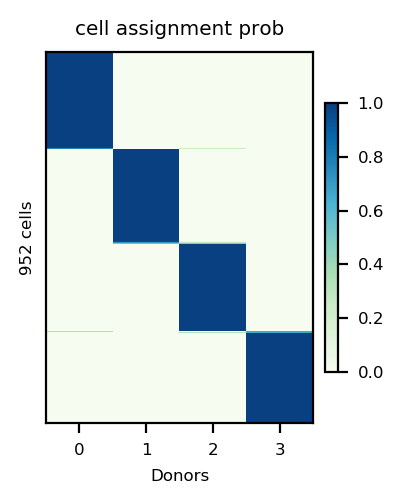

In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6})
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(2, 2.5), dpi=200)
im = heat_matrix(res['ID_prob'], cmap="GnBu", alpha=1,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("cell assignment prob")
plt.xlabel("Donors")
plt.ylabel("%d cells" %(res['ID_prob'].shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()

In [11]:
## If ASE_mode is True
AF_mean = res['theta_shapes'][:, 0] / np.sum(res['theta_shapes'], axis=1)

_new_shape = (AF_mean.shape[1], AF_mean.shape[0], 1)
AF_SNPs = np.sum(res['GT_prob'] * AF_mean.transpose().reshape(_new_shape), axis=1)

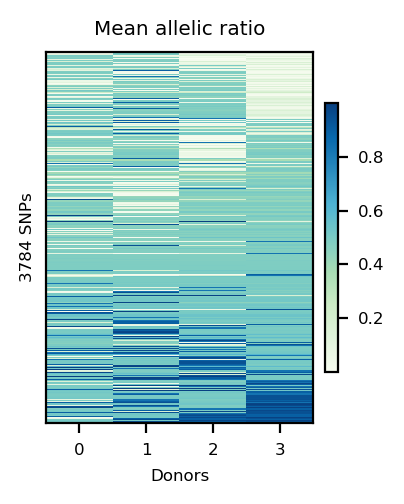

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6})
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(2, 2.5), dpi=200)
im = heat_matrix(AF_SNPs, cmap="GnBu", alpha=1,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Donors")
plt.ylabel("%d SNPs" %(AF_SNPs.shape[0]))
plt.yticks([])
plt.xticks([0, 1, 2, 3])

plt.tight_layout()
plt.show()